
 __Scientific Computing, TU Berlin, WS 2019/2020, Lecture 17__

 Jürgen Fuhrmann, WIAS Berlin



## Implementation of the finite element method


# Packages to be used

In [1]:
using Triangulate
using PyPlot
using ExtendableSparse
using SparseArrays
using Printf

┌ Info: Recompiling stale cache file /home/fuhrmann/.julia/compiled/v1.2/ExtendableSparse/0S5ix.ji for ExtendableSparse [95c220a8-a1cf-11e9-0c77-dbfce5f500b3]
└ @ Base loading.jl:1240



## Plot  grid input/output

In [2]:
function plotpair(Plotter::Module, triin, triout;voronoi=nothing)
    if ispyplot(Plotter)
        PyPlot=Plotter
        PyPlot.clf()
        PyPlot.subplot(121)
        PyPlot.title("In")
        plot(PyPlot,triin)
        PyPlot.subplot(122)
        PyPlot.title("Out")
        Triangulate.plot(PyPlot,triout,voronoi=voronoi)
    end
end

plotpair (generic function with 1 method)


## Plot function on grid

In [3]:
function plot(Plotter::Module,u,pointlist, trianglelist)
    cmap="coolwarm"
    levels=10
    t=transpose(trianglelist.-1)
    x=view(pointlist,1,:)
    y=view(pointlist,2,:)
    ax=Plotter.matplotlib.pyplot.gca()
    ax.set_aspect(1)
    #  tricontour/tricontourf takes triangulation as argument
    Plotter.tricontourf(x,y,t,u,levels=levels,cmap=cmap)
    PyPlot.colorbar(shrink=0.5)
    Plotter.tricontour(x,y,t,u,levels=levels,colors="k")
end

plot (generic function with 1 method)


## Plot grid and function on grid

In [4]:
function plotpair(Plotter::Module,u,triout)
    if ispyplot(Plotter)
        PyPlot=Plotter
        PyPlot.clf()
        PyPlot.subplot(121)
        PyPlot.title("Grid")
        Triangulate.plot(PyPlot,triout)
        PyPlot.subplot(122)
        PyPlot.title("Solution")
        plot(PyPlot,u,triout.pointlist, triout.trianglelist)
    end

end

plotpair (generic function with 1 method)

In [5]:
function compute_edge_matrix(itri, pointlist, trianglelist)
    i1=trianglelist[1,itri];
    i2=trianglelist[2,itri];
    i3=trianglelist[3,itri];

    V11= pointlist[1,i2]- pointlist[1,i1];
    V12= pointlist[1,i3]- pointlist[1,i1];

    V21= pointlist[2,i2]- pointlist[2,i1];
    V22= pointlist[2,i3]- pointlist[2,i1];

    det=V11*V22 - V12*V21;
    vol=0.5*det
    return (V11,V12,V21,V22,vol)
end

compute_edge_matrix (generic function with 1 method)

In [6]:
function  compute_local_stiffness_matrix!(local_matrix,itri, pointlist,trianglelist)

    (V11,V12,V21,V22,vol)=compute_edge_matrix(itri, pointlist, trianglelist)

    fac=0.25/vol

    local_matrix[1,1] = fac * (  ( V21-V22 )*( V21-V22 )+( V12-V11 )*( V12-V11 ) );
    local_matrix[2,1] = fac * (  ( V21-V22 )* V22          - ( V12-V11 )*V12 );
    local_matrix[3,1] = fac * ( -( V21-V22 )* V21          + ( V12-V11 )*V11 );

    local_matrix[2,2] =  fac * (  V22*V22 + V12*V12 );
    local_matrix[3,2] =  fac * ( -V22*V21 - V12*V11 );

    local_matrix[3,3] =  fac * ( V21*V21+ V11*V11 );

    local_matrix[1,2] = local_matrix[2,1];
    local_matrix[1,3] = local_matrix[3,1];
    local_matrix[2,3] = local_matrix[3,2];
    return vol
end

compute_local_stiffness_matrix! (generic function with 1 method)


## Assembly of matrix (for Dirichlet)

In [7]:
function  assemble!(matrix, # Global stiffness matrix
                    rhs,    # Right hand side vector
                    frhs::Function, # Source/sink function
                    gbc::Function,  # Boundary condition function
                    pointlist,
                    trianglelist,
                    segmentlist)
    num_nodes_per_cell=3;
    ntri=size(trianglelist,2)
    vol=0.0
    local_stiffness_matrix= [ 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0  0.0  0.0 ]
    local_massmatrix= [ 2.0 1.0 1.0; 1.0 2.0 1.0; 1.0  1.0  2.0 ]
    local_massmatrix./=12.0
    rhs.=0.0

    # Main part
    for itri in 1:ntri
        vol=compute_local_stiffness_matrix!(local_stiffness_matrix,itri, pointlist,trianglelist);
        for i  in 1:num_nodes_per_cell
            for j in 1:num_nodes_per_cell
                k=trianglelist[j,itri]
                x=pointlist[1,k]
                y=pointlist[2,k]
                rhs[trianglelist[i,itri]]+=vol*local_massmatrix[i,j]*frhs(x,y)
                matrix[trianglelist[i,itri],trianglelist[j,itri]]+=local_stiffness_matrix[i,j]
            end
        end
    end
    # Assemble penalty terms for Dirichlet boundary conditions
    penalty=1.0e30
    nbface=size(segmentlist,2)
    for ibface=1:nbface
        for i=1:2
            k=segmentlist[i,ibface]
            matrix[k,k]+=penalty
            x=pointlist[1,k]
            y=pointlist[2,k]
            rhs[k]+=penalty*gbc(x,y)
        end
    end
end

assemble! (generic function with 1 method)


## Run things

In [8]:
function example1(;plotgrid=false)
    triin=TriangulateIO()
    triin.pointlist=Matrix{Cdouble}([-1.0 -1.0; 1.0 -1.0 ; 1.0 1.0 ; -1.0 1.0 ]')
    triin.segmentlist=Matrix{Cint}([1 2 ; 2 3 ; 3 4 ; 4 1 ]')
    triin.segmentmarkerlist=Vector{Int32}([1, 2, 3, 4])
    (triout, vorout)=triangulate("pqa0.01qQD", triin)

    if plotgrid
        plotpair(PyPlot,triin,triout,voronoi=vorout)
        return
    end

    n=size(triout.pointlist,2)
    frhs(x,y)=1
    gbc(x,y)=0
    matrix=spzeros(n,n)
    rhs=zeros(n)
    assemble!(matrix,rhs, frhs,gbc,triout.pointlist,triout.trianglelist, triout.segmentlist)
    sol=matrix\rhs
    plotpair(PyPlot,sol,triout)
end

example1 (generic function with 1 method)

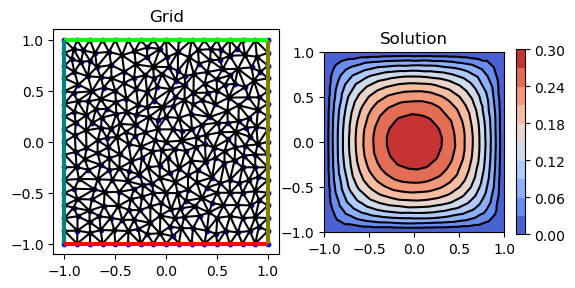

PyObject <matplotlib.tri.tricontour.TriContourSet object at 0x7f3f9521cc18>

In [9]:
example1()


## Calculate norms of solution

In [10]:
function norms(u,pointlist,trianglelist)
    l2norm=0.0
    h1norm=0.0
    num_nodes_per_cell=3
    ntri=size(trianglelist,2)
    local_stiffness_matrix= [ 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0  0.0  0.0 ]
    local_mass_matrix= [ 2.0 1.0 1.0; 1.0 2.0 1.0; 1.0  1.0  2.0 ]
    local_mass_matrix./=12.0
    for itri=1:ntri
        vol=compute_local_stiffness_matrix!(local_stiffness_matrix,itri, pointlist,trianglelist);
        for i  in 1:num_nodes_per_cell
            for j in 1:num_nodes_per_cell
                uij=u[trianglelist[j,itri]]*u[trianglelist[i,itri]]
                l2norm+=uij*vol*local_mass_matrix[j,i]
                h1norm+=uij*local_stiffness_matrix[j,i]
            end
        end
    end
    return (sqrt(l2norm),sqrt(h1norm));
end

norms (generic function with 1 method)


## Calculate largest edge lentgh

In [11]:
function hmax(pointlist,trianglelist)
    num_edges_per_cell=3
    local_edgenodes=zeros(Int32,2,3)
    local_edgenodes[1,1]=2
    local_edgenodes[2,1]=3

    local_edgenodes[1,2]=3
    local_edgenodes[2,2]=1

    local_edgenodes[1,3]=1
    local_edgenodes[2,3]=2

    h=0.0
    ntri=size(trianglelist,2)
    for itri=1:ntri
        for iedge=1:num_edges_per_cell
            k=trianglelist[local_edgenodes[1,iedge],itri]
            l=trianglelist[local_edgenodes[2,iedge],itri]
            dx=pointlist[1,k]-pointlist[1,l]
            dy=pointlist[2,k]-pointlist[2,l]
            h=max(h,dx^2+dy^2)
        end
    end
    return sqrt(h)
end

hmax (generic function with 1 method)


## Convergence test with exact solution

In [12]:
function example2(;plotgrid=false,nref0=0, nref1=0,k=1,l=1)
    allh=[]
    alll2=[]
    allh1=[]
    if nref0>nref1
        nref1=nref0
    end
    for iref=nref0:nref1
        triin=TriangulateIO()
        triin.pointlist=Matrix{Cdouble}([-1.0 -1.0; 1.0 -1.0 ; 1.0 1.0 ; -1.0 1.0 ]')
        triin.segmentlist=Matrix{Cint}([1 2 ; 2 3 ; 3 4 ; 4 1 ]')
        triin.segmentmarkerlist=Vector{Int32}([1, 2, 3, 4])
        area=0.1*2.0^(-2*iref)
        s_area=@sprintf("%.20f",area)
        (triout, vorout)=triangulate("pqa$(s_area)qQD", triin)

        h=hmax(triout.pointlist,triout.trianglelist)

        n=size(triout.pointlist,2)
        fexact(x,y)=sin(k*pi*x)*sin(l*pi*y);
        uexact=zeros(n)
        for i=1:n
            uexact[i]=fexact(triout.pointlist[1,i],triout.pointlist[2,i])
        end
        frhs(x,y)=(k^2+l^2)*pi^2*fexact(x,y);
        gbc(x,y)=0
        # Use ExtendableSparse for faster matrix construction
        matrix=ExtendableSparseMatrix(n,n)
        rhs=zeros(n)
        assemble!(matrix,rhs, frhs,gbc,triout.pointlist,triout.trianglelist, triout.segmentlist)
        sol=matrix\rhs
        plotpair(PyPlot,sol,triout)
        (l2norm,h1norm)=norms(uexact-sol,triout.pointlist,triout.trianglelist)
        @show l2norm,h1norm
        push!(allh,h)
        push!(allh1,h1norm)
        push!(alll2,l2norm)
    end
    if nref1>nref0
        PyPlot.clf()
        PyPlot.grid()
        PyPlot.xlabel("h")
        PyPlot.ylabel("error")
        PyPlot.loglog(allh, alll2, label="l2",color=:green,marker="o")
        PyPlot.loglog(allh, allh.^2, label="O(h^2)",color=:green)
        PyPlot.loglog(allh, allh1, label="h1",color=:red,marker="o")
        PyPlot.loglog(allh, allh, label="O(h)",color=:red)
        PyPlot.legend()
    end
end

example2 (generic function with 1 method)


Run example

(l2norm, h1norm) = (0.14899945927425381, 0.7965359487301439)
(l2norm, h1norm) = (0.05215103340493323, 0.3116209287873366)
(l2norm, h1norm) = (0.014419819284894388, 0.12093859705297158)
(l2norm, h1norm) = (0.0037477006855091244, 0.05721121087032019)
(l2norm, h1norm) = (0.0009472318323417062, 0.0289601433249114)
(l2norm, h1norm) = (0.00023577329865166099, 0.014044351994046666)
(l2norm, h1norm) = (5.874545149346516e-5, 0.007025182460982775)
(l2norm, h1norm) = 

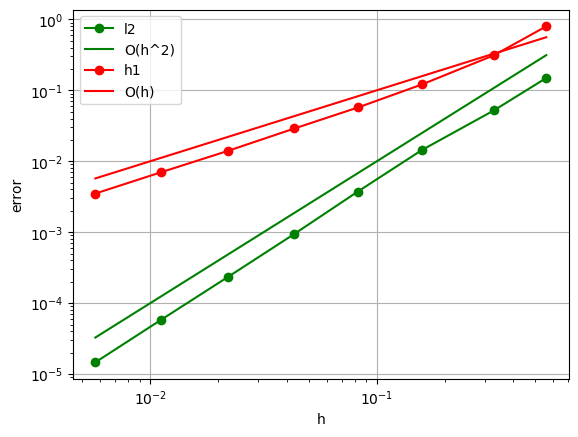

(1.4684503155289194e-5, 0.0035070610191345283)


PyObject <matplotlib.legend.Legend object at 0x7f3f87781c18>

In [14]:
example2(nref0=0, nref1=7)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*